# Homework 2 using laplace approximation

I realized in other soultion I didn't stick to the book and contents covered only till then. So now doing a solution that is true to spirits. 

In [1]:
import jax.numpy as np
import pandas as pd
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, init_to_median, SVI, Trace_ELBO, init_to_value
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer.reparam import LocScaleReparam, TransformReparam
import numpyro.distributions as dist
import numpyro.optim as optim
from plotnine import *
from scipy.interpolate import BSpline
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
rng_key = random.PRNGKey(0)
theme_set( theme_seaborn(style='darkgrid'))
%config InlineBackend.figure_format ='retina'

## Homework Week2

https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week02.pdf


### Question 1

>The weights listed below were recorded in the !Kung census, but heights were not recorded for the weights 45, 40, 65, 31 and 53. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

>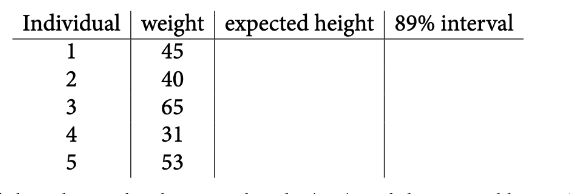

So the way I see this question is basically build a model and then use posterior to make predictions. 

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0


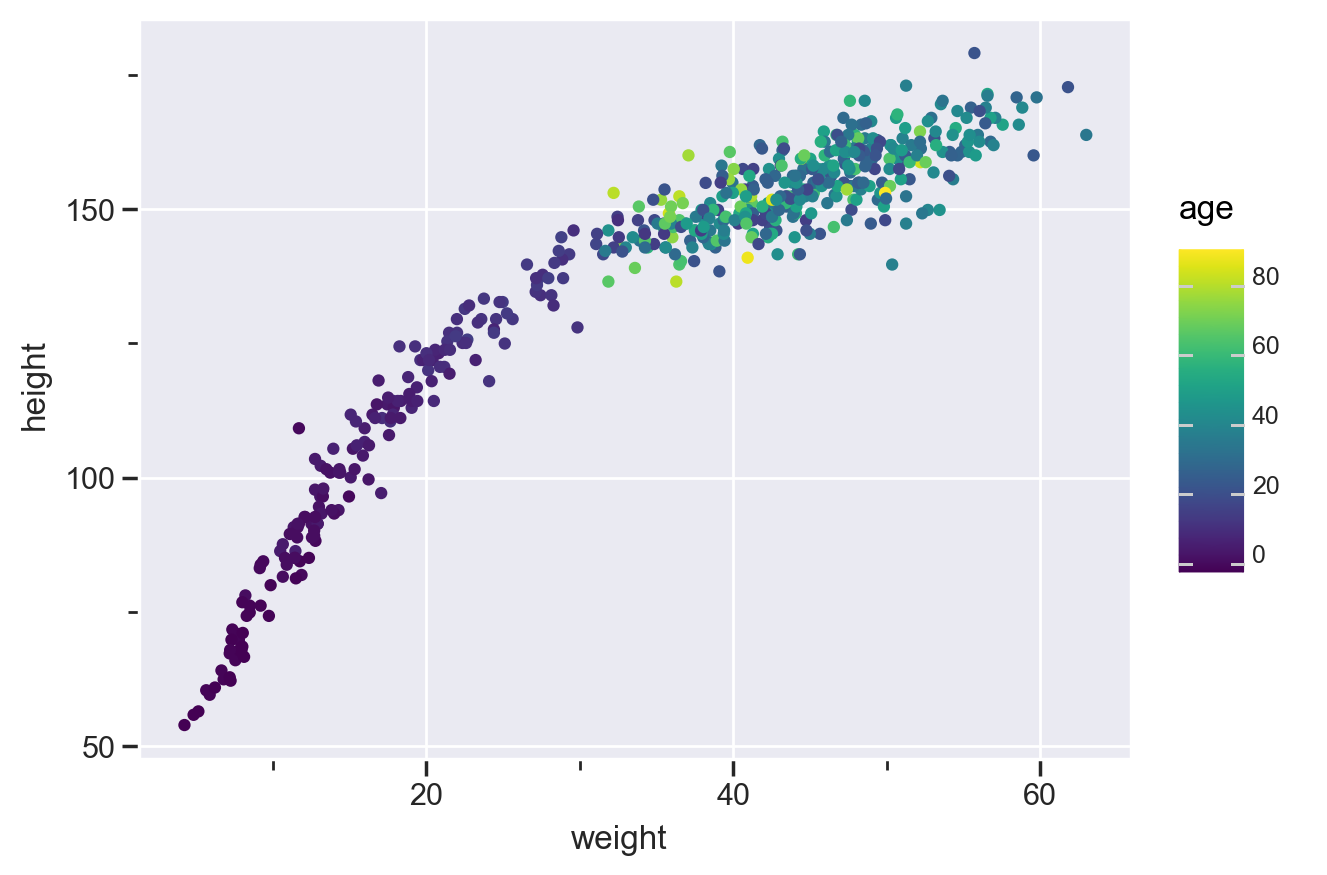

<ggplot: (8764536278375)>

In [2]:
df_data = pd.read_csv("../data/Howell1.csv",sep=";")
print(df_data.head())
(
    ggplot(df_data,aes(x='weight', y='height', color='age')) +
    geom_point() 
)

Looking at this plot and weights we have been asked to do predictions for, a linear model for height vs weight would do. However the plot also shows doing linear model for age  >=20 might look better

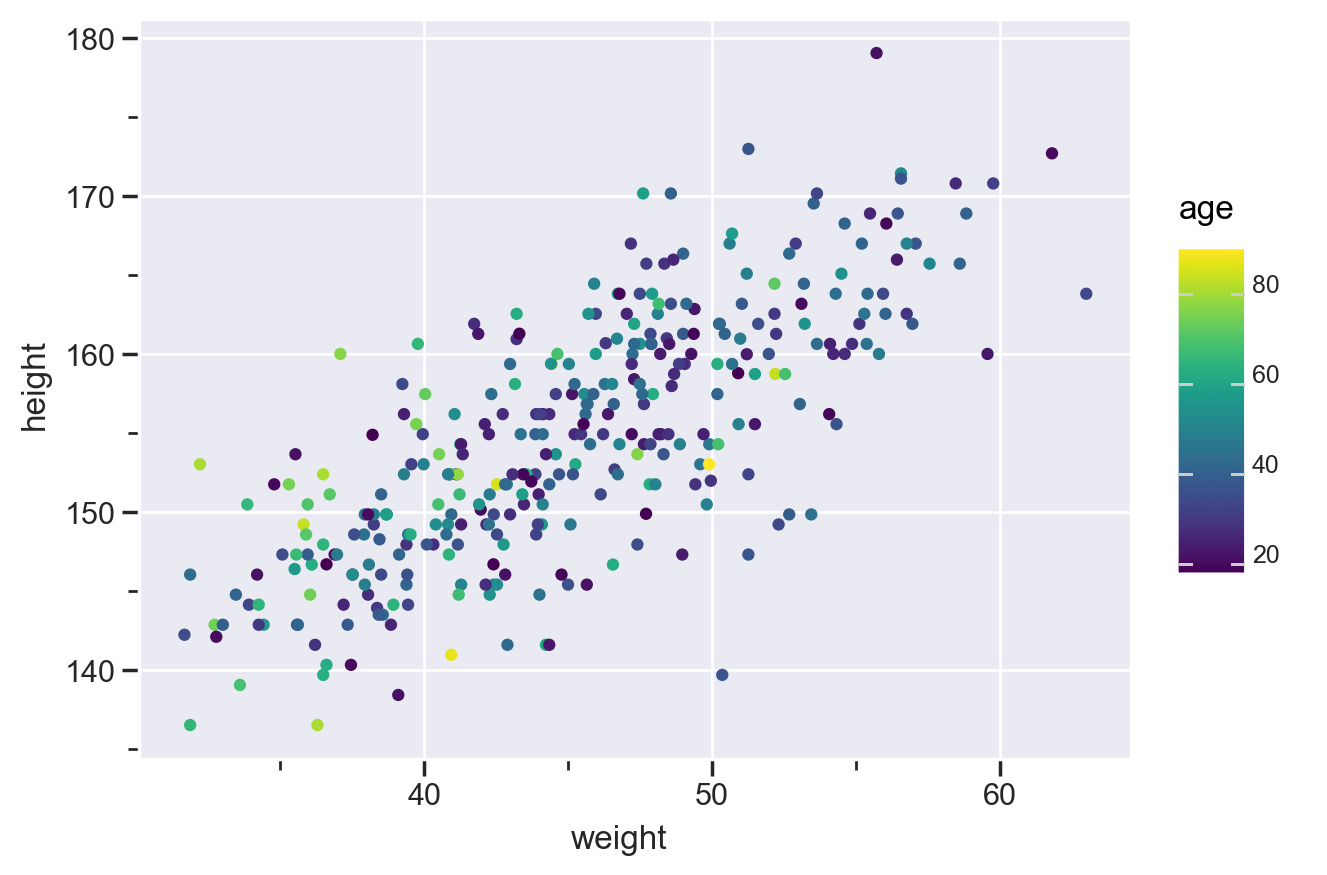

<ggplot: (8764537990777)>

In [3]:
d1 = df_data[df_data.age>=20]
(
    ggplot(d1,aes(x='weight', y='height', color='age')) +
    geom_point() 
)

**You might be tempted to use a model as $h_i = \alpha + \beta * w_i$, however here term $\alpha$ would mean height of person when weight is zero. Firstly this is bit absurd and we have no prior around it. What we have prior around is average height of inidividuals. So formulating model as $h_i = \alpha + \beta * (\bar{w}-w_i)$ would make a more sense, where $\bar{w}$ is mean weight of individuals. 

In [4]:
w_bar = np.mean(d1.weight.values)
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta = numpyro.sample('beta', dist.LogNormal(0,1))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta * (weight-w_bar))
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [5]:
guide = AutoLaplaceApproximation(model)
svi = SVI(guide.model, guide, optim.Adam(1), Trace_ELBO(), weight = d1.weight.values, height = d1.height.values)
svi_result = svi.run(rng_key, 5000)
svi_params = svi_result.params
svi_params_posterior = guide.sample_posterior(rng_key, svi_params, (1000,))
pp = guide.sample_posterior(rng_key, svi_params, (1000,))
pp.pop("mu")
print_summary(pp,0.89, False) ## as we have no chains need False

100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2558.79it/s, init loss: 38940.7305, avg. loss [4751-5000]: 1035.0751]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha    154.72      0.28    154.72    154.29    155.18   1143.47      1.00
      beta      0.94      0.04      0.94      0.86      1.00   1002.52      1.00
     sigma      5.09      0.20      5.09      4.78      5.41   1004.76      1.00



**Now to get the predictions we can just use predictive and pass it new values at which we need predictions. The steps are as follows:***

* get posterior
* call predictive with that posterior and pass values you want to get predictions for


I will first do it for the trained values to see how well we do there and then will do it for new values. 



In [6]:
def plot_pred_interval(data):
    p = (
        ggplot(data,aes(x='weight', y='height')) +
        geom_point(alpha=0.5) +
        geom_line(aes(y='expected height'),color='dodgerblue') +
        geom_ribbon(aes(ymin='lower',ymax='higher'), fill='dodgerblue', alpha=0.3) 
    )
    return p

/Users/smishra/anaconda3/envs/statrethinking/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/smishra/anaconda3/envs/statrethinking/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


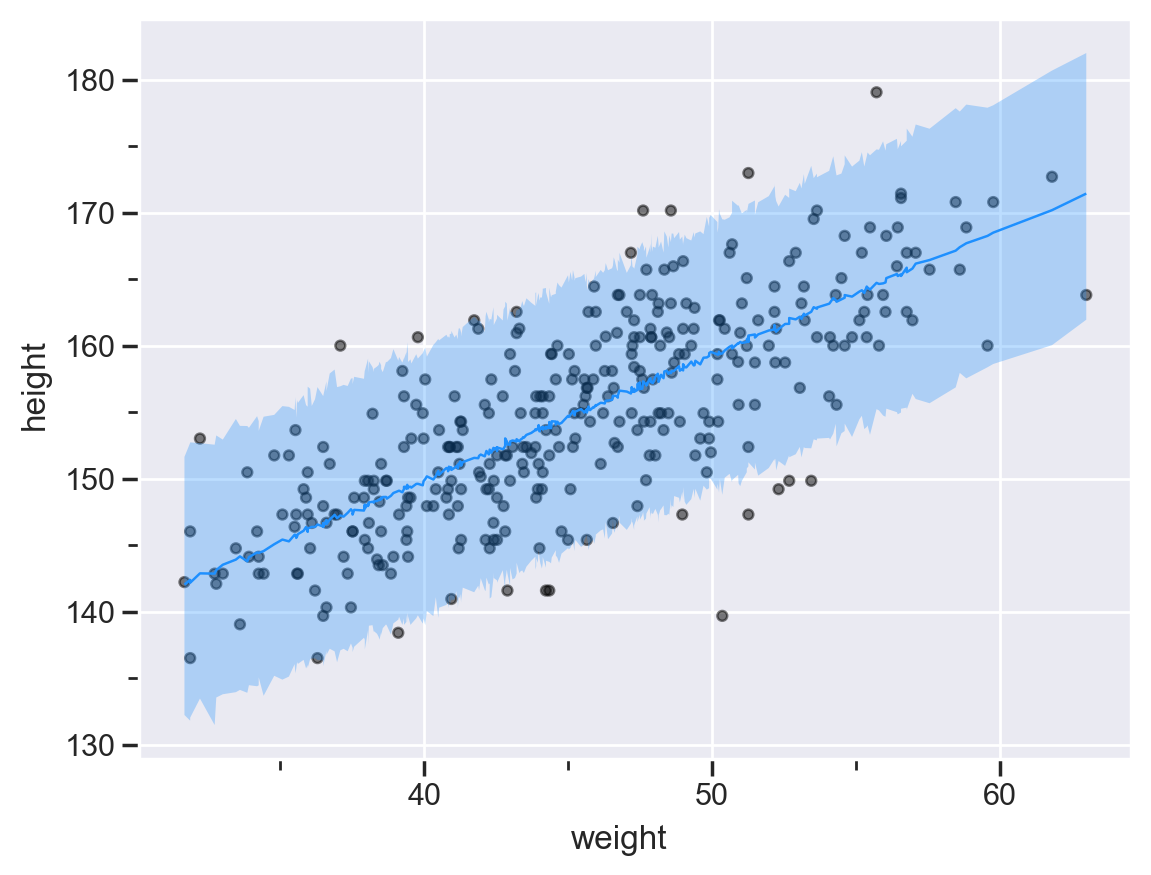

<ggplot: (8764585939836)>

In [7]:
svi_posterior_pred = Predictive(guide.model, svi_params_posterior)(rng_key, d1.weight.values )
d1.loc[:, "expected height"] = np.mean(svi_posterior_pred['height_hat'],axis=0)
pred_hpdi = np.percentile(svi_posterior_pred['height_hat'], q=(2.5, 97.5), axis=0)
d1.loc[:, "lower"] = pred_hpdi[0]
d1.loc[:, "higher"] = pred_hpdi[1]
plot_pred_interval(d1)

Now doing predictions for new points

In [8]:
weights = np.array([45,40,65,31,53])
predictions = Predictive(guide.model, svi_params_posterior)(rng_key, weights)
df_pred = pd.DataFrame([(hpdi(s,prob=0.89),np.mean(s)) for s in predictions['height_hat']._value.T])
df_pred.loc[:, 'Weight'] = weights
df_pred.rename(columns={0:'89% CI', 1:'Expected Height'},inplace=True)
df_pred = df_pred.reindex(columns=['Weight','Expected Height', '89% CI'])
df_pred

,Weight,Expected Height,89% CI
0,45,154.56476,"[146.10738, 162.31929]"
1,40,150.04991,"[142.74988, 158.88342]"
2,65,173.50882,"[165.44162, 181.01628]"
3,31,141.65498,"[133.80861, 149.64491]"
4,53,162.07918,"[154.79622, 170.85031]"


### Question 2

>Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 (from the book) that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data

    height     weight   age  male  log_weight
0  151.765  47.825606  63.0     1    3.867561
1  139.700  36.485807  63.0     0    3.596923
2  136.525  31.864838  65.0     0    3.461503
3  156.845  53.041914  41.0     1    3.971082
4  145.415  41.276872  51.0     0    3.720302


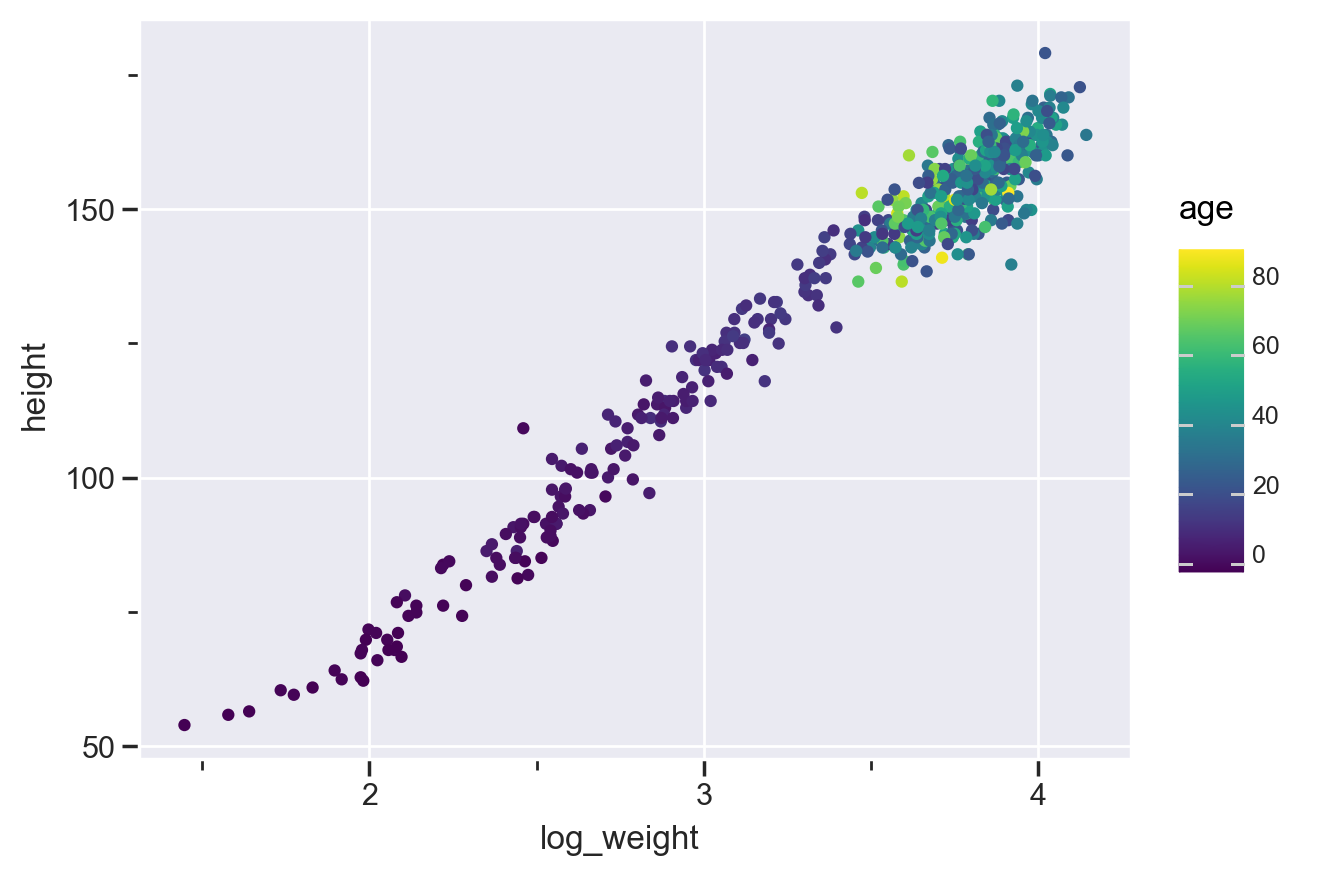

<ggplot: (8764604012023)>

In [9]:
d2 = df_data
d2.loc[:,('log_weight')] = np.log(d2.weight.values)
print(df_data.head())
(
    ggplot(d2,aes(x='log_weight', y='height', color='age')) +
    geom_point()
)

Will first try a linear model (why not!!)

In [10]:
w_bar = np.mean(d2.log_weight.values)
def model_lr(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta = numpyro.sample('beta', dist.Normal(0,10))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + beta * (weight-w_bar))
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [11]:
guide = AutoLaplaceApproximation(model_lr)
svi = SVI(guide.model, guide, optim.Adam(1), Trace_ELBO(), weight = d2.log_weight.values, height = d2.height.values)
svi_result = svi.run(rng_key, 5000)
svi_params = svi_result.params
svi_params_posterior = guide.sample_posterior(rng_key, svi_params, (1000,))
pp = guide.sample_posterior(rng_key, svi_params, (1000,))
pp.pop("mu")
print_summary(pp,0.89, False) ## as we have no chains need False

100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3285.33it/s, init loss: 50271.7617, avg. loss [4751-5000]: 1684.4664]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha    138.27      0.22    138.27    137.93    138.63   1143.46      1.00
      beta     47.04      0.37     47.06     46.34     47.53   1005.02      1.00
     sigma      5.13      0.16      5.12      4.87      5.37    986.47      1.00



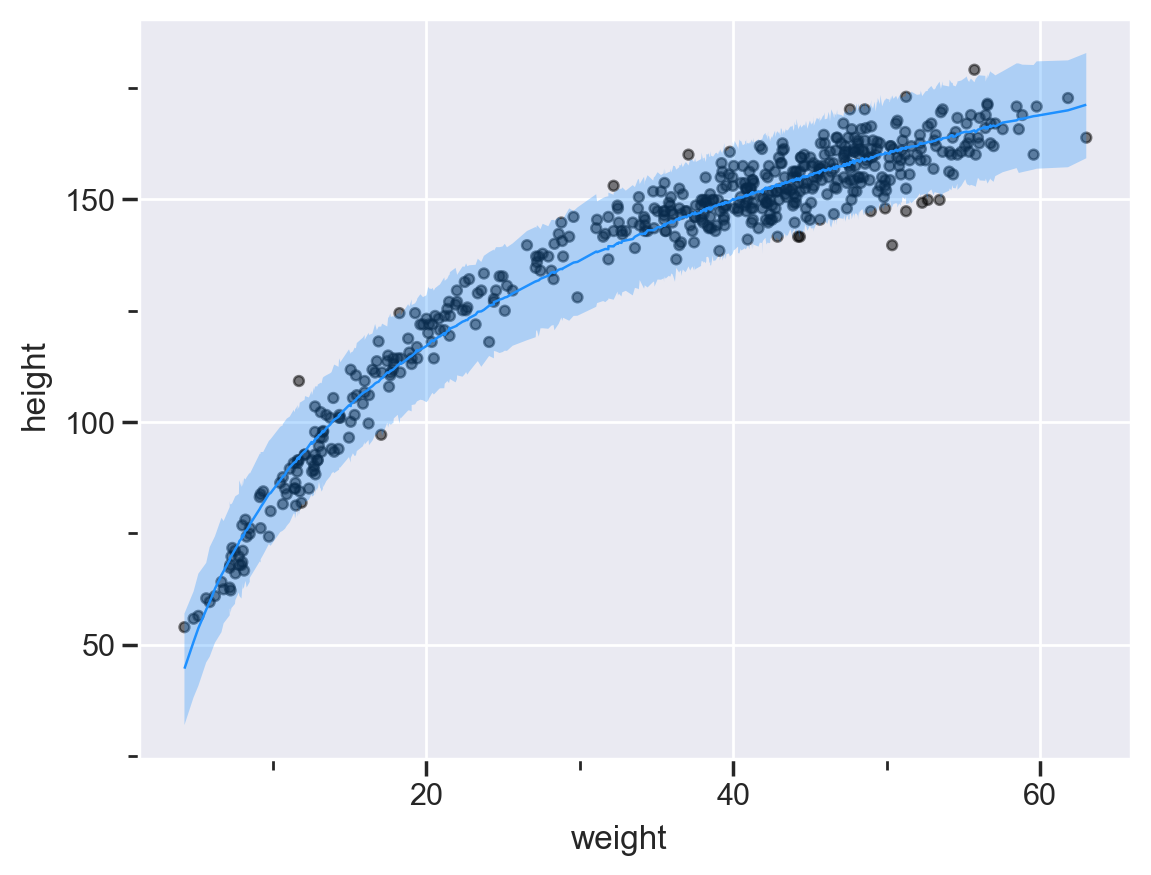

<ggplot: (8764569043839)>

In [12]:
svi_posterior_pred = Predictive(guide.model, svi_params_posterior)(rng_key, d2.log_weight.values )
d2.loc[:, "expected height"] = np.mean(svi_posterior_pred['height_hat'],axis=0)
pred_hpdi = np.percentile(svi_posterior_pred['height_hat'], q=(1, 99), axis=0)
d2.loc[:, "lower"] = pred_hpdi[0]
d2.loc[:, "higher"] = pred_hpdi[1]
plot_pred_interval(d2)

For God's sake this linear regression should have worked line a breeze. But $\beta\sim\mathcal{LN}(0,1)$ and $\beta\sim\mathcal{N}(0,1)$ just do not work!! beyond me 

**Few things I will like to revisit:**
- [ ] log(wt) linear regression with other values
- [ ] implement a B-spline model
- [ ] Actually compare MCMC with laplace approximation results

### Question 3

>Plot the prior predictive distribution for the polynomial regression model in Chapter 4 (just what we did in the previous exercise). You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of $\alpha$, $\beta_1$, and $\beta_2$ so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data

Trying only polynomial of degree 2 as once we increase the degree more we will need to guess our priors and interactions between them. 
 
 ***Remember reason all this is very weird to do is that once we have more interactions terms especially in polynomial model the prior predictive is essentially interactions between uncorrleated coefficients, however the shape of the curve is very much correlated with coefficients (combination is important not just individual values*** 

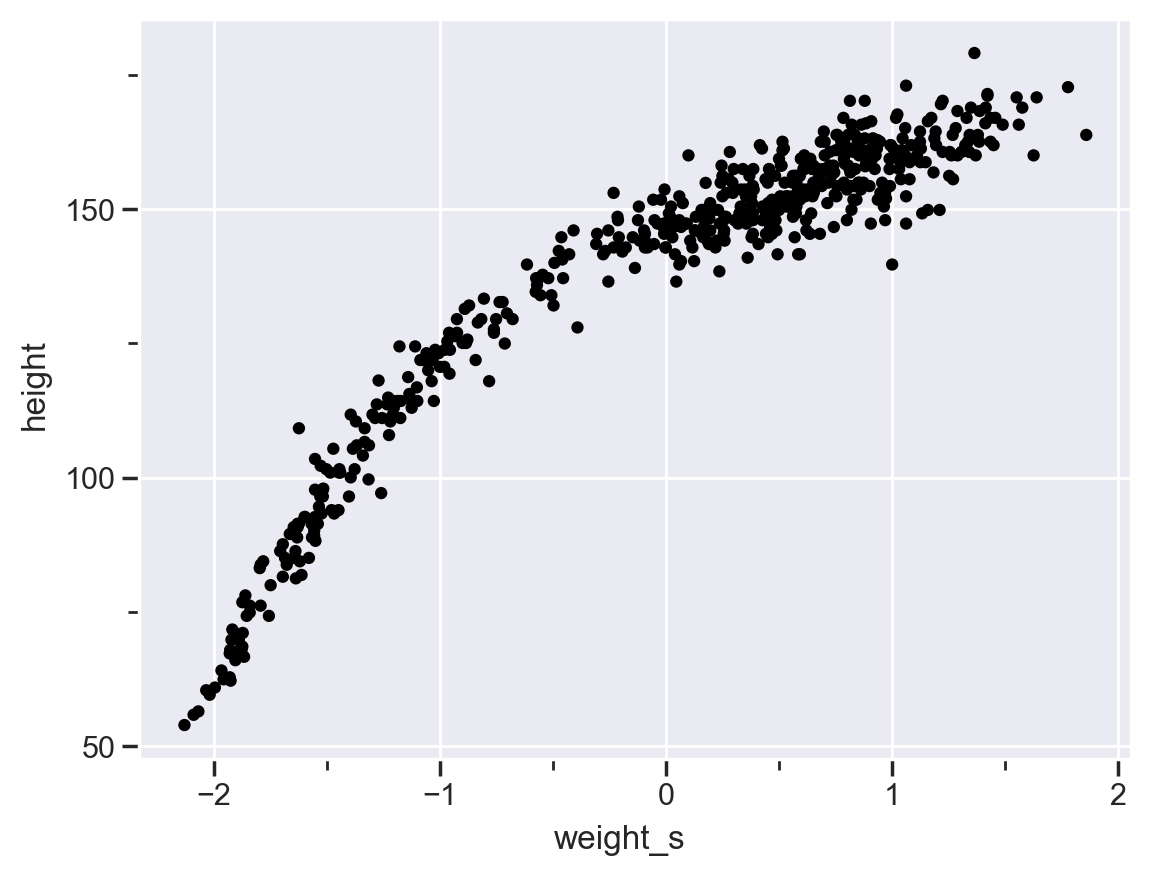

<ggplot: (8764536278342)>

In [13]:
d3 = df_data
d3["weight_s"] = (d3.weight - d3.weight.mean()) / d3.weight.std() ## standardrize data
d3["weight_s2"] = d3.weight_s ** 2

(
    ggplot(d3,aes(x='weight_s', y='height')) +
    geom_point() 
)

 My thought process is I need a prior that sort of start to bend as I move away to far right. I will try to keep prior on linear term (linear here term with no power for explanatory variable) same as the model above $\mathcal{LN}\sim(0,1)$ and play just with prior on quadratic term. Also as I need my curve to bend down or flatten out; I will actually need the coeff for quadratic term to be negative (or programtically easier way is just replace sign from + to - in front of $\beta_2$ and make it then positive). 
 
 This might turn out to be a bad idea, but really I have no other way to think about priors.

In [14]:
def model_poly1(weight_s, weight_s2,height=None):
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))
    beta1 = numpyro.sample("beta1", dist.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", dist.Normal(0, 1)) ## beta not restricted to be positive
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", alpha + beta1 * weight_s - beta2 * weight_s2)
    numpyro.sample("height_hat", dist.Normal(mu, sigma), obs=height)
    
def model_poly2(weight_s, weight_s2,height=None):
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))
    beta1 = numpyro.sample("beta1", dist.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", dist.HalfNormal(1)) ## beta restricted to be positive via halfnormal
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", alpha + beta1 * weight_s - beta2 * weight_s2)
    numpyro.sample("height_hat", dist.Normal(mu, sigma), obs=height)
    
def model_poly3(weight_s, weight_s2,height=None):
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))
    beta1 = numpyro.sample("beta1", dist.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", dist.LogNormal(0, 1)) ## beta restricted to be positive via log normal
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", alpha + beta1 * weight_s - beta2 * weight_s2)
    numpyro.sample("height_hat", dist.Normal(mu, sigma), obs=height)
    
def model_poly4(weight_s, weight_s2,height=None):
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))
    beta1 = numpyro.sample("beta1", dist.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", dist.LogNormal(1, 1)) ## beta restricted to be positive via log normal but shifted a bit to 
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", alpha + beta1 * weight_s - beta2 * weight_s2)
    numpyro.sample("height_hat", dist.Normal(mu, sigma), obs=height)
    
def get_priors(model=None, model_name = None , num_samples = 50, data = d3):
    if (model==None or model_name==None):
        print("No model/model name passed")
        return None
    svi_prior_pred = Predictive(model, num_samples=num_samples)(rng_key, data.weight_s.values, data.weight_s2.values)
    df_prior = pd.DataFrame(svi_prior_pred['mu'].T)
    df_prior = pd.concat([data.weight_s,df_prior], axis=1)
    df_prior = df_prior.melt(id_vars=['weight_s'],value_name='height', var_name='prior')
    df_prior['model_name'] = model_name
    return df_prior 
    

In [15]:
p1 = get_priors(model_poly1, model_name="beta1~LN(0,1), beta2~N(0,1)")
p2 = get_priors(model_poly2, model_name="beta1~LN(0,1), beta2~HN(1)")
p3 = get_priors(model_poly3, model_name="beta1~LN(0,1), beta2~LN(0,1)")
p4 = get_priors(model_poly4, model_name="beta1~LN(0,1), beta2~LN(1,1)")
pr = pd.concat([p1,p2,p3,p4])

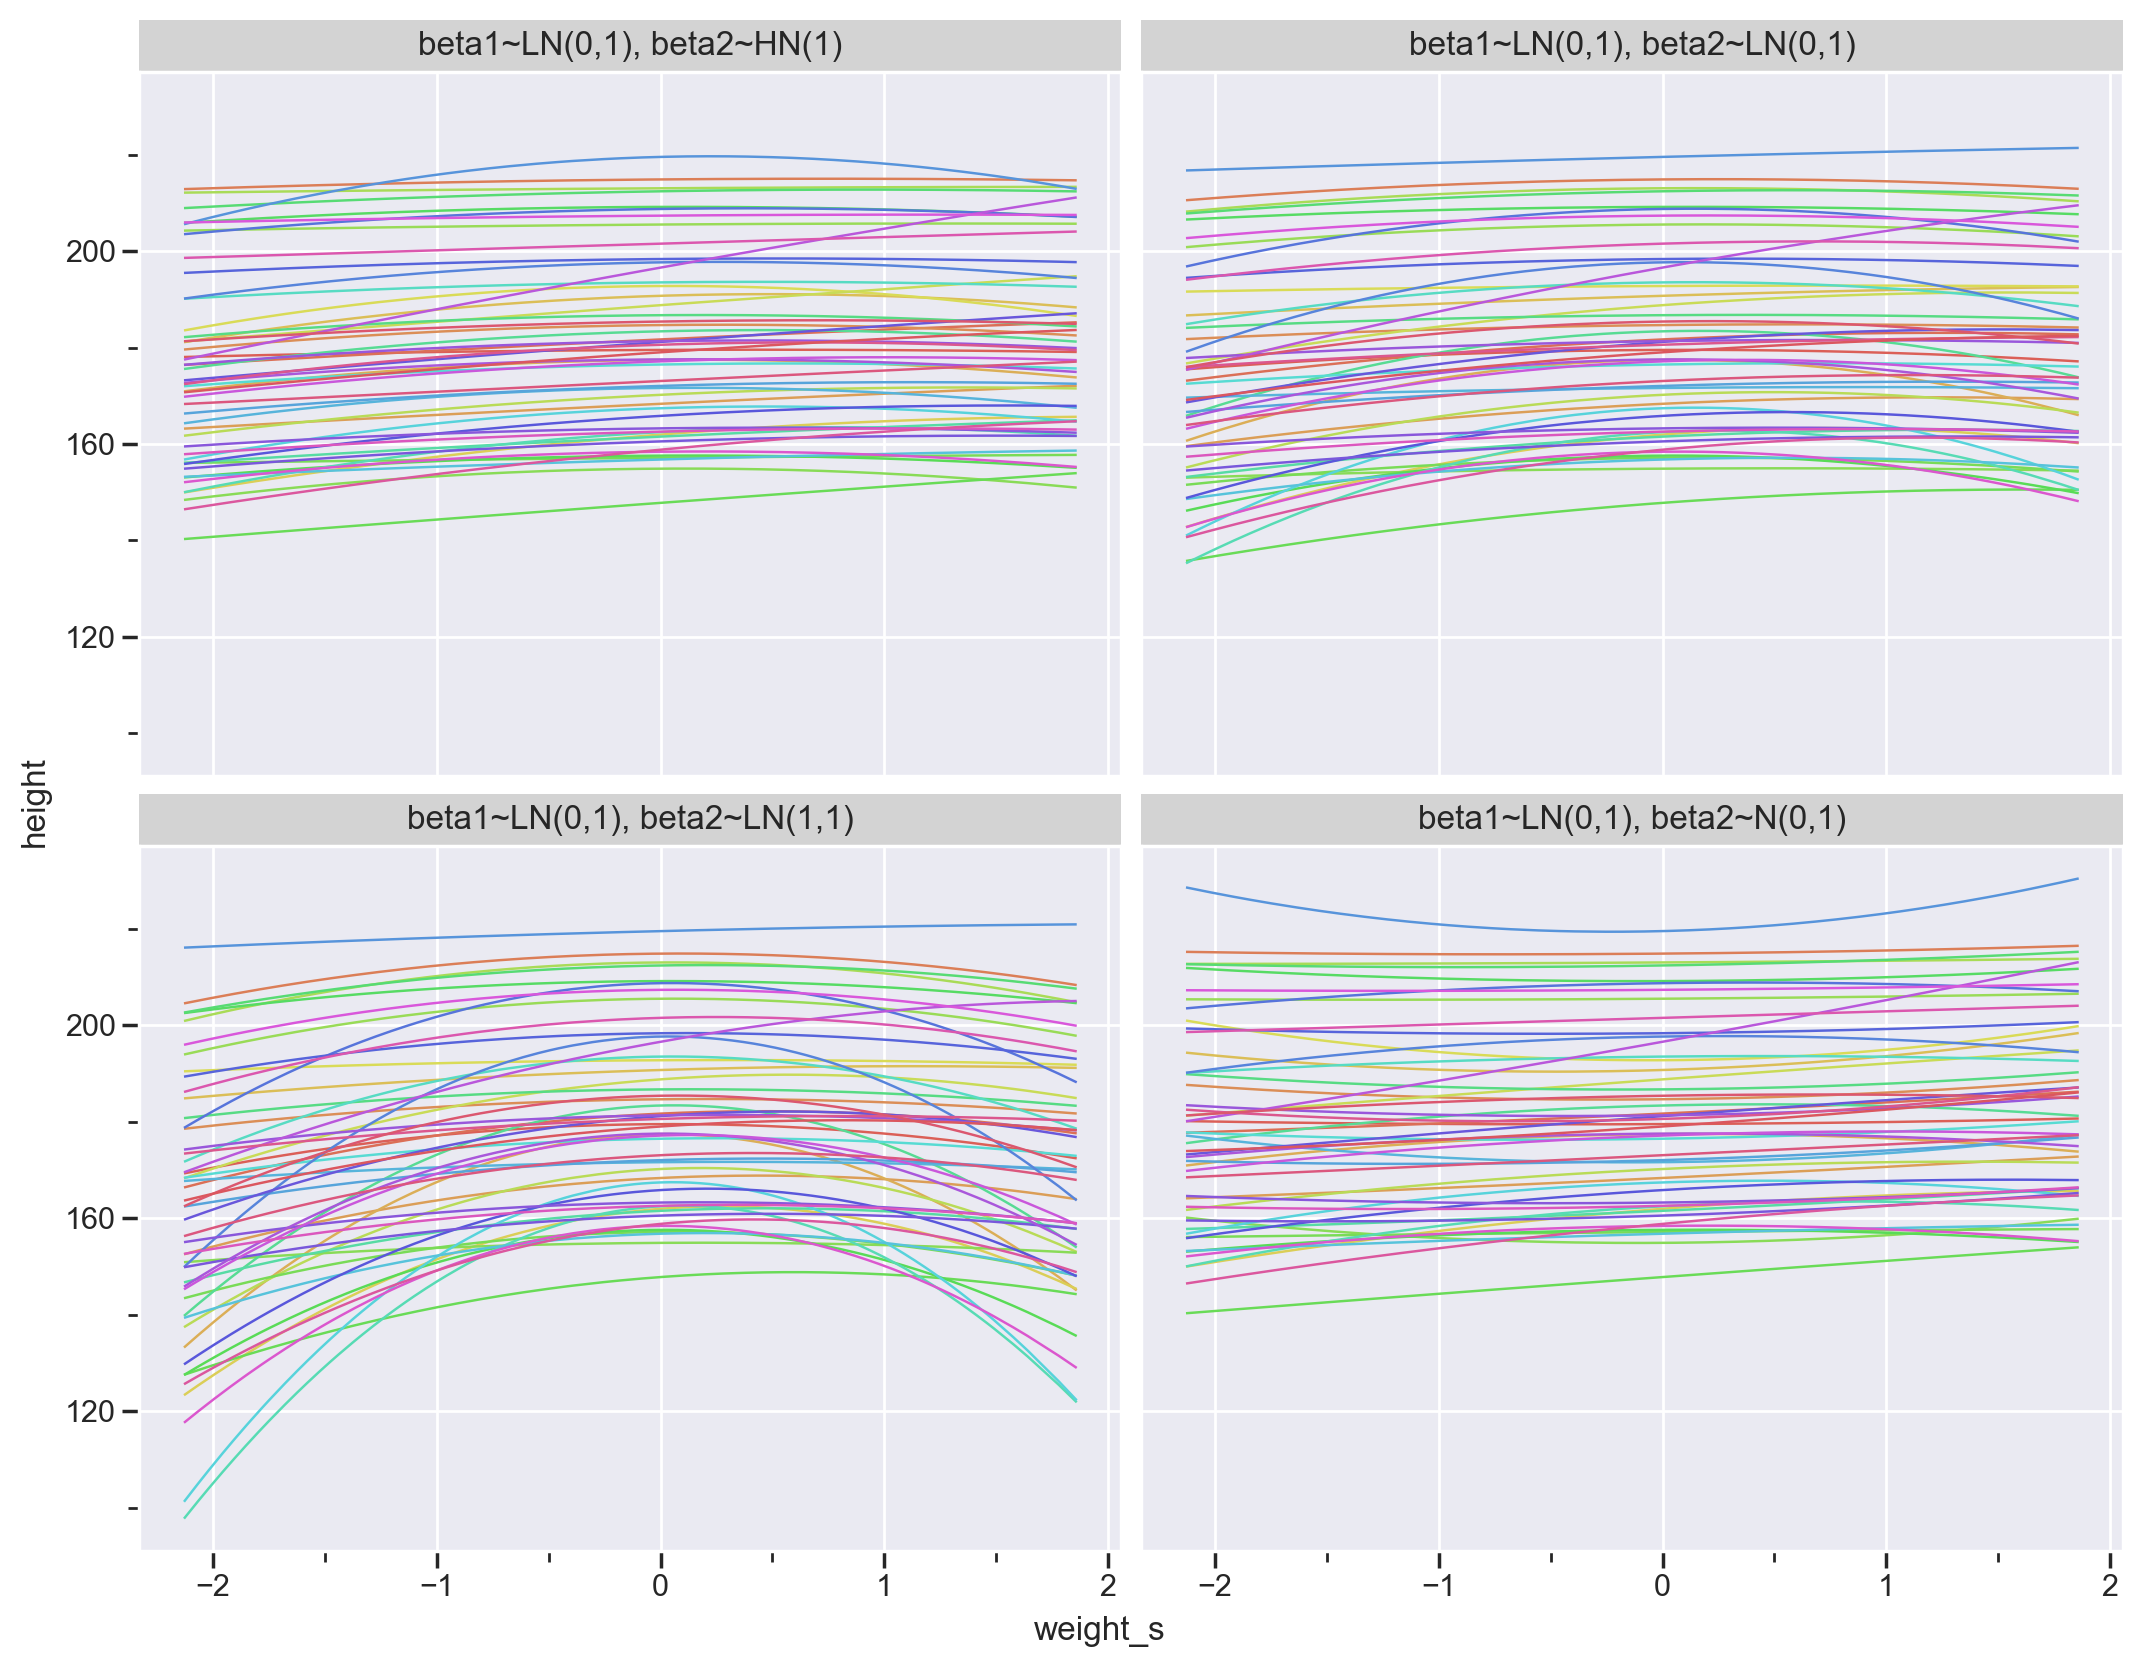

<ggplot: (8764605123606)>

In [16]:
(
    ggplot(pr,aes(x='weight_s', y='height', color='prior')) +
    geom_line() +
    facet_wrap('~model_name', ncol=2) +
    theme(figure_size=(12.8, 9.6), legend_position="none") 
    
)

Looking at plots above my feel is this, yes $\beta_2$ needs to be positive always else you see this weird behaviour of curve bending upwards as seen for prior $\beta_2\sim\mathcal{N}(0,1)$. Other observation is that I need the bending to happen a bit more towards the right.

In [17]:
def model_poly5(weight_s, weight_s2,height=None):
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))
    beta1 = numpyro.sample("beta1", dist.LogNormal(2, 1)) ## increasing mean so that bending is seen a bit later
    beta2 = numpyro.sample("beta2", dist.LogNormal(1, 1)) ## beta restricted to be positive via log normal but shifted a bit to 
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", alpha + beta1 * weight_s - beta2 * weight_s2)
    numpyro.sample("height_hat", dist.Normal(mu, sigma), obs=height)
    
def model_poly6(weight_s, weight_s2,height=None):
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))
    beta1 = numpyro.sample("beta1", dist.Normal(30, 10)) ## increasing mean so that bending is seen a bit later
    beta2 = numpyro.sample("beta2", dist.LogNormal(1, 1)) ## beta restricted to be positive via log normal but shifted a bit to 
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", alpha + beta1 * weight_s - beta2 * weight_s2)
    numpyro.sample("height_hat", dist.Normal(mu, sigma), obs=height)

In [18]:
p5 = get_priors(model_poly5, model_name="beta1~LN(2,1), beta2~LN(1,1)")
p6 = get_priors(model_poly6, model_name="beta1~N(30,10), beta2~LN(1,1)")
pr = pd.concat([p5,p6])

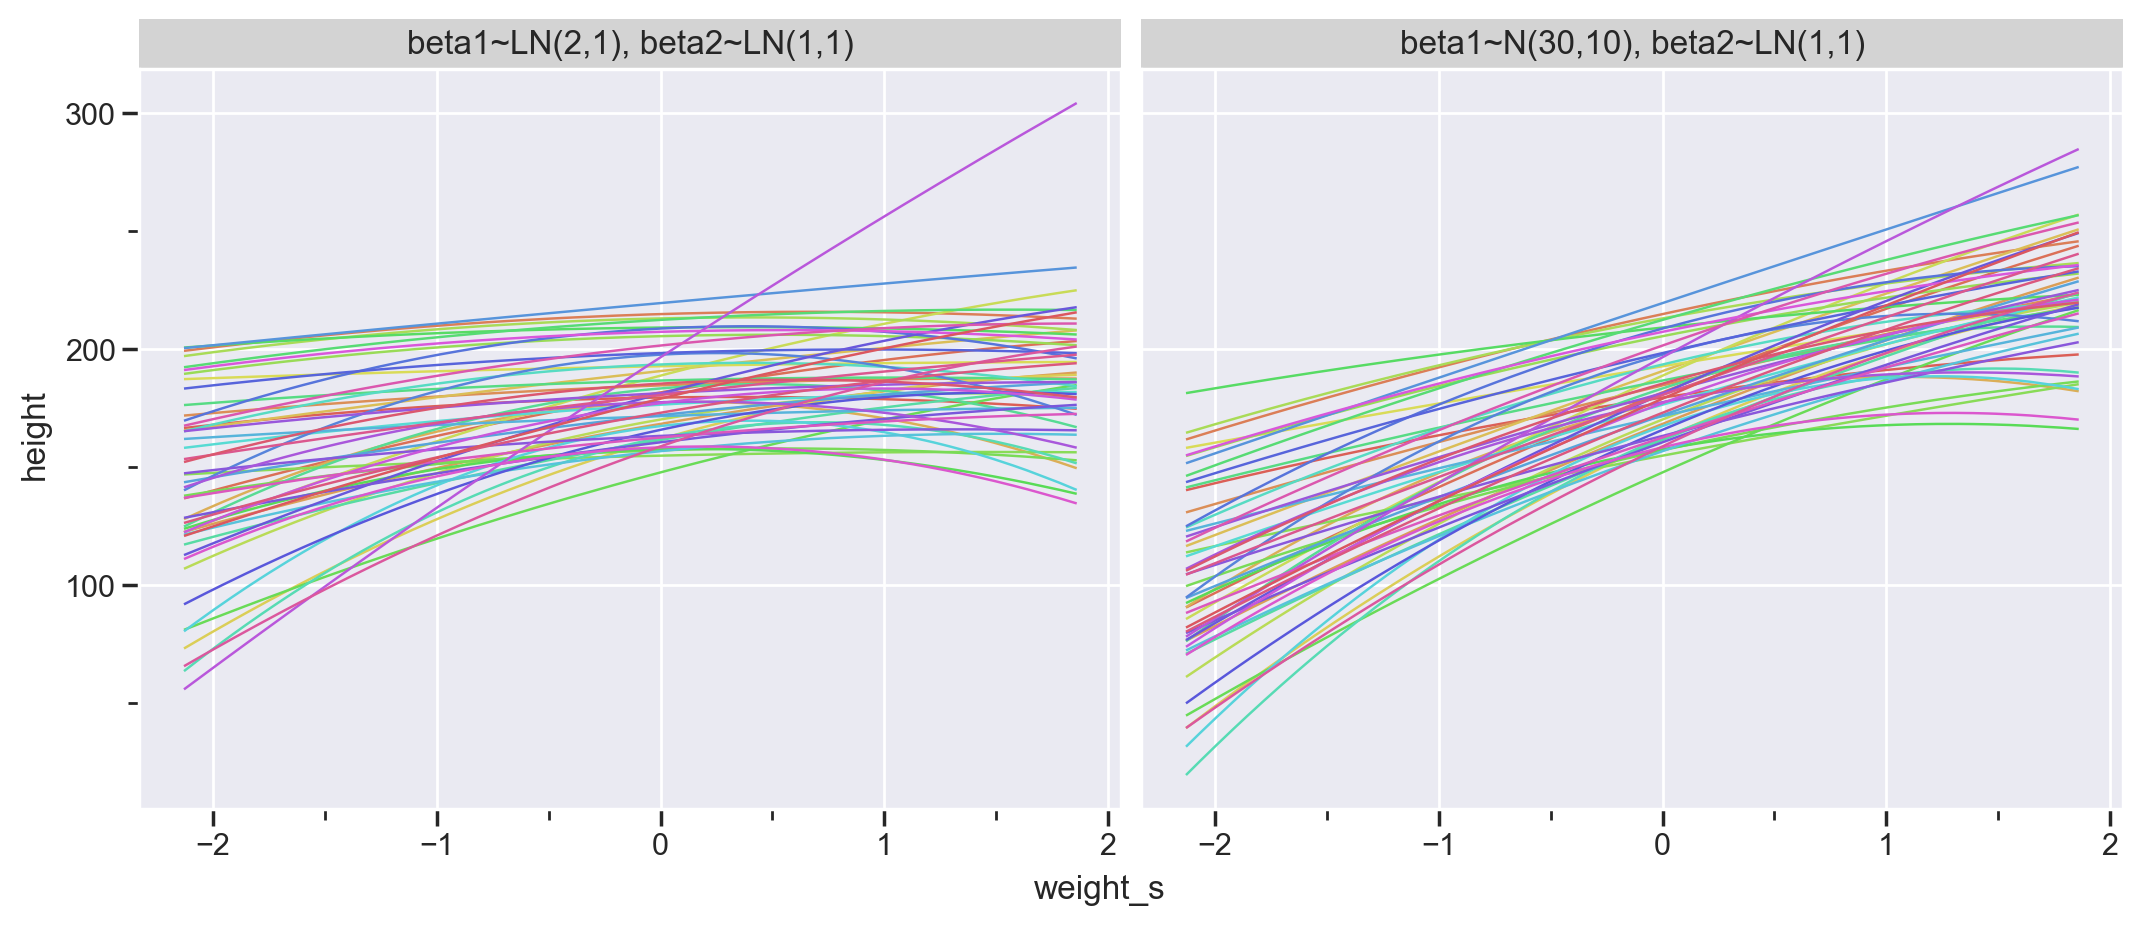

<ggplot: (8764518477180)>

In [19]:
(
    ggplot(pr,aes(x='weight_s', y='height', color='prior')) +
    geom_line() +
    facet_wrap('~model_name', ncol=2) +
    theme(figure_size=(12.8, 4.8), legend_position="none") 
    
)

Both above seems a decent option to me now